# Import Library

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

# Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_EW.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_EW']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_NS.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_NS']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_UD.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_UD']
C=CC[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
train_xx=np.hstack((raw_data1,C))

#print(train_xx.shape)


train_y=label.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(train_y[0])
#print(train_y.shape)

In [4]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(3,1,300)).T)

In [5]:
train_x=np.array(train_x)

In [6]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 3))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# CRNN-Dis architecture, training and testing

In [7]:
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 3), name='input_layer') 

    e = Conv1D(128, 9, padding = 'same')(inp1) 
    e = ReLU()(e)
    e = MaxPooling1D(2, padding='same')(e)
# 
    e = Conv1D(128, 7, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(2, padding='same')(e)

    e = Conv1D(128, 5, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(2, padding='same')(e)
    
    e = Conv1D(128, 3, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(2, padding='same')(e)



  


    
    e = Bidirectional(LSTM(100, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)
    e = tf.keras.layers.Dense(128,activation='relu')(e) # 全连接层，14节点  0.340
    e = layers.Dropout(rate=0.5)(e)
    e = tf.keras.layers.Dense(128,activation='relu')(e) # 全连接层，14节点  0.340
    e = layers.Dropout(rate=0.5)(e) 
    e = Dense(1)(e)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [8]:
model = get_model()
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 300, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          3584      
_________________________________________________________________
re_lu (ReLU)                 (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 128)          114816    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 150, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 128)          

In [9]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(33)
#np.random.seed(seed)
#random.seed(seed)

#session_conf = tf.compat.v1.ConfigProto(
#    intra_op_parallelism_threads=1, 
#    inter_op_parallelism_threads=1
#)
#sess = tf.compat.v1.Session(
#    graph=tf.compat.v1.get_default_graph(), 
#    config=session_conf
#)
#tf.compat.v1.keras.backend.set_session(sess)

pred_train_all=np.zeros(train_y.shape)
#pred_test_all = np.zeros(test_y.shape)
#pred_zhenli_all = np.zeros(y_zhenli.shape)

    
#es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)


In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 13s 81ms/step - loss: 2690.0361 - val_loss: 1704.2019
Epoch 2/300
162/162 [==============================] - 12s 76ms/step - loss: 1533.9288 - val_loss: 1368.5010
Epoch 3/300
162/162 [==============================] - 14s 87ms/step - loss: 1366.0842 - val_loss: 1040.1663
Epoch 4/300
162/162 [==============================] - 16s 96ms/step - loss: 1196.2955 - val_loss: 1025.8318 - los - ETA: 1s - loss: 1190. - ETA: 1s - los - ETA: 0s - loss:
Epoch 5/300
162/162 [==============================] - 16s 98ms/step - loss: 1121.1794 - val_loss: 947.9971A: 12s -  - ETA: 12s - loss: 1 - ETA: 12s - loss: 1092.4 - ETA: 12s - loss: 110 - ETA: 11s - loss: 1098.60 - ETA:  - ETA: 9s - l - ETA: 9s - l - ETA: 5s - loss: - ETA: 5s - l - ETA: 4s - loss: 113 - ETA - ETA: 3s - l - ETA: 2s - loss: 1134. - ETA: 2s - ETA: 1s - loss: 113 - ETA: 0s - loss: 1120.
Epoch 6/300
162/162 [==============================] - 18s 109ms/step - loss: 1056.8181 - val_lo

In [11]:
# 保存权重（推荐方式）
model.save_weights("CRNN_Dis_weights.h5")  # HDF5格式

In [12]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))

Model size (MB): 1.8131141662597656


训练标准差STD= 0.16468392201081475
训练误差均值MEAN= 0.022084144754314194
训练平均绝对误差MAE= 0.12181068592892906
训练RMSE= 0.1661580681712255
训练MAPE= 14.838414082654902
训练r2 score: 0.7777924164242793


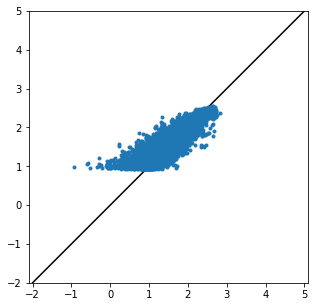

In [13]:
from sklearn import metrics
from sklearn.metrics import r2_score
pred_train_all[pred_train_all <= 0] = 10
train_y=np.log10(train_y) 
pred_train_all=np.log10(pred_train_all)

print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()

In [14]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True LGED','Pred LGED']
writer_tr = pd.ExcelWriter(r'\CRNN-Dis\distrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

In [15]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_EW.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_EW']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_NS.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_NS']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_UD.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_UD']
Cz=CCz[:,0:300]



labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [16]:
raw_data1z=np.hstack((Az,Bz))
x_dataz=np.hstack((raw_data1z,Cz))


zhenli_y=labelz.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(zhenli_y[0])
#print(zhenli_y.shape)

In [17]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(3,1,300)).T)

In [18]:
zhenli_x=np.array(zhenli_x)

In [19]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 3))

In [19]:
zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 3)
print(zhenli_x1.shape)


(1, 300, 3)


In [22]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict(zhenli_x1).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 38.77 ms


震例标准差STD= 0.187084206712449
震例误差均值MEAN= 0.011010981219613063
震例平均绝对误差MAE= 0.1391043949578402
震例RMSE= 0.1874079563643044
震例MAPE= 13.256941089892496
震例r2 score: 0.7378330622091988


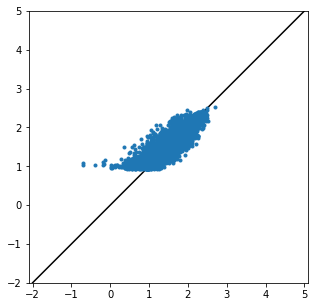

In [20]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列
pred_zhenli_all[pred_zhenli_all <= 0] = 10
zhenli_y=np.log10(zhenli_y) 
pred_zhenli_all=np.log10(pred_zhenli_all)


print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  

In [21]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True LGED','Pred LGED']
writer_tz = pd.ExcelWriter(r'\CRNN-Dis\distest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# Test on the Chinese strong-ground motion data

In [22]:
#在中国地区应用
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_UD']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_EW']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_NS']
Cz_CH=CCz_CH[:,0:300]



labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))

In [23]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
x_dataz_CH=np.hstack((raw_data1z_CH,Cz_CH))


y_dataz_CH=labelz_CH.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz_CH[0])
#print(y_dataz_CH.shape)

In [24]:
zhenli_y_CH=y_dataz_CH

In [25]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(3,1,300)).T)

In [26]:
zhenli_x_CH=np.array(zhenli_x_CH)

In [27]:
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 3))

In [28]:
pred_zhenli_all_CH = model.predict(zhenli_x_CH).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.25495168662574796
震例误差均值MEAN= 0.17702926700473515
震例平均绝对误差MAE= 0.2371869646845226
震例RMSE= 0.31038641060708083
震例MAPE= 17.600691318931457
震例r2 score: 0.2024239343424672


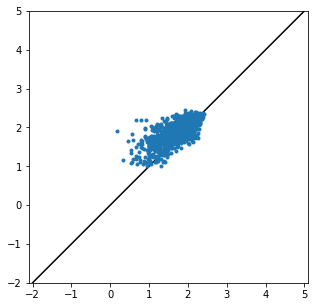

In [29]:
pred_zhenli_all_CH[pred_zhenli_all_CH <= 0] = 10
zhenli_y_CH=np.log10(zhenli_y_CH) 
pred_zhenli_all_CH=np.log10(pred_zhenli_all_CH)

print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  